Author: Haotian Tan  
Final Checked by Oct. 8th, 2025

In [1]:
import warnings

# DeprecationWarning is due to groupby.apply

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# SHAP analysis

In [2]:
import pandas as pd

df = pd.read_csv(r"merged_all_models_persona.csv")

df["Cost"] = df["amount_of_cost"]
df["Unfairness"] = 30 - 2*df["amount_of_allocation"]
df["Emotional Valence"] = df["AA_valence"]
df["Emotional Arousal"] = df["AA_arousal"]


## XGBoost and SHAP analysis

In [3]:
import pandas as pd
import shap
import xgboost as xgb
from sklearn.model_selection import train_test_split

features = ["Cost", "Unfairness", "Emotional Valence", "Emotional Arousal"]
NormSHAP_results = []  

for g, g_df in df.groupby("group"):
    X = g_df[features]  
    y = g_df["choice"]

    # Spilt the data by 7:2:1 for train, validation and test   
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=2025
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42025
    )

    split = pd.Series(index=g_df.index, dtype="object")
    split.loc[X_train.index] = "train"
    split.loc[X_val.index] = "val"
    split.loc[X_test.index] = "test"

    # trian the XGBClassifier
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=200,
        max_depth=3,
        learning_rate=0.15,
        subsample=0.5,
        colsample_bytree=0.5,
        eval_metric="logloss",
        random_state=2025
    )
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Model prediction 
    pred_prob = model.predict_proba(X)[:, 1]
    pred_choice = (pred_prob >= 0.5).astype(int)

    # SHAP analysis
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X).values


    shap_df = pd.DataFrame(
        shap_values, columns=[f"SHAP_{c}" for c in features], index=g_df.index
    )

    # Normalized SHAP
    shap_abs_sum = shap_df.abs().sum(axis=1) 
    norm_shap_df = shap_df.div(shap_abs_sum, axis=0)  
    norm_shap_df.columns = [f"NormSHAP_{c}" for c in features]

    # output
    g_result = pd.concat(
        [
            g_df[["id", "trial", "group"]].reset_index(drop=True),  
            g_df[features].reset_index(drop=True),                  
            shap_df.reset_index(drop=True),                       
            norm_shap_df.reset_index(drop=True),               
            g_df[["choice"]].reset_index(drop=True),                
            pd.DataFrame({"pred_prob": pred_prob, "pred_choice": pred_choice}),
            split.reset_index(drop=True).rename("split")            
        ],
        axis=1
    )
    NormSHAP_results.append(g_result)

NormSHAP_results = pd.concat(NormSHAP_results, ignore_index=True)
#NormSHAP_results.to_csv("shap_results.csv", index=False)

e:\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# the weighted NormSHAP
shap_mapping = {
    'NormSHAP_Emotional Valence': 'Emotional Valence',
    'NormSHAP_Emotional Arousal': 'Emotional Arousal',
    'NormSHAP_Cost': 'Cost',
    'NormSHAP_Unfairness': 'Unfairness'  
}

def add_corr(group_df):
    for shap_col, orig_col in shap_mapping.items():
        corr_list = []
        ids = group_df['id'].unique()
        for i in ids:
            sub_df = group_df[group_df['id'] == i]
            if sub_df[shap_col].nunique() > 1 and sub_df[orig_col].nunique() > 1:
                corr_val = sub_df[shap_col].corr(sub_df[orig_col])
            else:
                corr_val = 0
            corr_list.extend([corr_val] * len(sub_df))
        group_df[shap_col + '_corr'] = corr_list
    return group_df


Weighted_NormSHAP_results = NormSHAP_results.groupby('group').apply(add_corr).reset_index(drop=True)

Weighted_NormSHAP_results["NormSHAP_E"] = abs(Weighted_NormSHAP_results['NormSHAP_Emotional Valence']) * Weighted_NormSHAP_results['NormSHAP_Emotional Valence_corr'] * (-1) + \
                    abs(Weighted_NormSHAP_results['NormSHAP_Emotional Arousal']) * Weighted_NormSHAP_results['NormSHAP_Emotional Arousal_corr']
Weighted_NormSHAP_results["NormSHAP_R"] = abs(Weighted_NormSHAP_results['NormSHAP_Cost']) * Weighted_NormSHAP_results['NormSHAP_Cost_corr']

Weighted_NormSHAP_results.to_csv("shap_results_weighted.csv", index=False)

## Results of model perfomance and SHAP

supplementary table 5.1.1

In [5]:
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# get model performance in test dataset
df = pd.read_csv("shap_results_weighted.csv")

results_list = []

for (split, g), g_df in df.groupby(["split", "group"]):
    y_true = g_df["choice"]
    y_pred = g_df["pred_choice"]
    y_prob = g_df["pred_prob"]

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    results_list.append({
        "split": split,
        "group": g,
        "accuracy": acc,
        "auc": auc
    })

metrics_df = pd.DataFrame(results_list)
metrics_df.to_csv("xgb_oos_performance.csv", index=False)

for split, split_df in metrics_df.groupby("split"):
    print(f"=== {split.upper()} ===")
    print(split_df.round(4).to_string(index=False))
    print()


=== TEST ===
split       group  accuracy    auc
 test DeepSeek-R1    0.9356 0.9696
 test DeepSeek-V3    0.9882 0.9990
 test     GPT-3.5    0.8804 0.8444
 test       Human    0.7674 0.8215
 test     o3-mini    0.9143 0.9660

=== TRAIN ===
split       group  accuracy    auc
train DeepSeek-R1    0.9394 0.9726
train DeepSeek-V3    0.9890 0.9991
train     GPT-3.5    0.8801 0.8411
train       Human    0.7705 0.8264
train     o3-mini    0.9194 0.9706

=== VAL ===
split       group  accuracy    auc
  val DeepSeek-R1    0.9359 0.9741
  val DeepSeek-V3    0.9880 0.9988
  val     GPT-3.5    0.8771 0.8355
  val       Human    0.7604 0.8190
  val     o3-mini    0.9127 0.9694



In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score

np.random.seed(2025)

# Get 95%CI of model performce
# Note that model performance is calculated using the test data, while SHAP values are computed using all the data.

df = pd.read_csv("shap_results_weighted.csv")
test_df = df[df["split"] == "test"]

groups_order = ["Human", "GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
feature_cols = ["Cost", "Unfairness", "Emotional Valence", "Emotional Arousal"]
shap_cols = ["NormSHAP_" + f for f in feature_cols]

# The bootstrap procedure will take approximately 3 minutes to complete.
n_bootstrap = 10000


# model performance of ACC with bootsrtap CI
mean_accs, lower_ci_acc, upper_ci_acc = [], [], []

for g in groups_order:
    g_df = test_df[test_df["group"] == g].copy()
    g_df['correct'] = g_df['choice'] == g_df['pred_choice']
    id_accs = g_df.groupby('id')['correct'].mean().values
    n = len(id_accs)

    samples_idx = np.random.randint(0, n, size=(n_bootstrap, n))
    boot_means = id_accs[samples_idx].mean(axis=1)

    mean_val = boot_means.mean()
    ci_lower = np.percentile(boot_means, 2.5)
    ci_upper = np.percentile(boot_means, 97.5)

    mean_accs.append(mean_val)
    lower_ci_acc.append(ci_lower)
    upper_ci_acc.append(ci_upper)


# model performance of ROC with bootsrtap CI
fpr_grid = np.linspace(0,1,100)
roc_results = {}
for g in groups_order:
    g_df = test_df[test_df["group"] == g]
    y_true = g_df["choice"].values
    y_prob = g_df["pred_prob"].values
    n = len(y_true)

    tprs, aucs = [], []

    for i in range(n_bootstrap):
        idx = np.random.randint(0, n, size=n)
        y_true_bs = y_true[idx]
        y_prob_bs = y_prob[idx]

        fpr, tpr, _ = roc_curve(y_true_bs, y_prob_bs)
        auc = roc_auc_score(y_true_bs, y_prob_bs)
        tpr_interp = np.interp(fpr_grid, fpr, tpr)

        tprs.append(tpr_interp)
        aucs.append(auc)

    tprs = np.array(tprs)
    mean_tpr = tprs.mean(axis=0)
    lower_tpr = np.percentile(tprs, 2.5, axis=0)
    upper_tpr = np.percentile(tprs, 97.5, axis=0)
    auc_mean = np.mean(aucs)
    auc_ci = (np.percentile(aucs, 97.5) - np.percentile(aucs, 2.5)) / 2
    auc_ci_upper = np.percentile(aucs, 97.5)
    auc_ci_lower = np.percentile(aucs,2.5)
    
    roc_results[g] = (mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci, auc_ci_upper, auc_ci_lower)

# Cummulative |Normalized SHAP|

shap_means = {col:[] for col in shap_cols}
shap_sds = {col:[] for col in shap_cols}

# 'lowers' and 'uppers' represent the 95% CI, calculated from the standard error (SE)
#shap_lowers = {col:[] for col in shap_cols}
#shap_uppers = {col:[] for col in shap_cols}

for g in groups_order:
    g_df = df[df["group"] == g].copy()
    g_df[shap_cols] = g_df[shap_cols].abs()
# The standard deviation (s.d.) is calculated across all trials. 
# To compute s.d. at the subject level instead, uncomment the code below.
# Note that this will generally result in smaller s.d. values.
#    g_df = g_df.groupby("id")[shap_cols].mean()
    
    for col in shap_cols:
        mean_val = g_df[col].mean()
        sd_val = g_df[col].std(ddof=1)
        shap_means[col].append(mean_val)
        shap_sds[col].append(sd_val)

#       se_val = id_shap[col].std(ddof=1)/np.sqrt(len(id_shap))
#       shap_lowers[col].append(mean_val - 1.96*sd_val)
#       shap_uppers[col].append(mean_val + 1.96*sd_val)

print("=== ACC with 95% CI ===")
for g, mean_val, low, up in zip(groups_order, mean_accs, lower_ci_acc, upper_ci_acc):
    print(f"{g}: bootstrap mean={mean_val:.4f}, 95% CI=({low:.4f}, {up:.4f})")

print("\n=== ROC with 95% CI ===")
for g in groups_order:
    mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci, auc_ci_upper, auc_ci_lower = roc_results[g]
    print(f"{g}: AUC={auc_mean:.4f} , 95% CI=({auc_ci_lower:.4f}, {auc_ci_upper:.4f})")
    print(f"bootstrap mean_tpr: {mean_tpr[:5]} ...")  
    print(f"lower_tpr: {lower_tpr[:5]} ...")
    print(f"upper_tpr: {upper_tpr[:5]} ...\n")

print("\n=== |Normalized SHAP| with sd ===")
for col in shap_cols:
    print(f"{col}:")
    for g, mean_val, sd in zip(groups_order, shap_means[col], shap_sds[col]):
        print(f"  {g}: mean={mean_val:.4f}, sd ={sd:.4f}")

=== ACC with 95% CI ===
Human: bootstrap mean=0.7670, 95% CI=(0.7560, 0.7780)
GPT-3.5: bootstrap mean=0.8789, 95% CI=(0.8727, 0.8850)
o3-mini: bootstrap mean=0.9130, 95% CI=(0.9063, 0.9195)
DeepSeek-V3: bootstrap mean=0.9887, 95% CI=(0.9865, 0.9908)
DeepSeek-R1: bootstrap mean=0.9355, 95% CI=(0.9295, 0.9413)

=== ROC with 95% CI ===
Human: AUC=0.8214 , 95% CI=(0.8139, 0.8290)
bootstrap mean_tpr: [0.00372131 0.15127543 0.23269032 0.28512901 0.33846409] ...
lower_tpr: [0.00045382 0.13196064 0.21175568 0.26076702 0.31494028] ...
upper_tpr: [0.01499106 0.1720162  0.2535229  0.31241421 0.36043609] ...

GPT-3.5: AUC=0.8445 , 95% CI=(0.8346, 0.8541)
bootstrap mean_tpr: [0.02726671 0.18846494 0.27046595 0.33184331 0.37234   ] ...
lower_tpr: [0.02133579 0.12938682 0.21983907 0.28491348 0.34166438] ...
upper_tpr: [0.05060395 0.23811065 0.31518933 0.37042148 0.40907067] ...

o3-mini: AUC=0.9660 , 95% CI=(0.9627, 0.9690)
bootstrap mean_tpr: [0.17407061 0.51329067 0.6276078  0.7181172  0.76702119] 

supplementary table 5.1.2

In [7]:
import pandas as pd

df = pd.read_csv("shap_results_weighted.csv")
corr_columns = [col for col in df.columns if col.endswith('_corr')]
df_grouped = df.groupby(['group', 'id'])[corr_columns].mean()
df_grouped = df_grouped.reset_index()
result_shap_corr = df_grouped.groupby('group')[corr_columns].agg(['mean', 'std'])
result_shap_corr = result_shap_corr.round(4)
print(result_shap_corr.to_string())

            NormSHAP_Emotional Valence_corr         NormSHAP_Emotional Arousal_corr         NormSHAP_Cost_corr         NormSHAP_Unfairness_corr        
                                       mean     std                            mean     std               mean     std                     mean     std
group                                                                                                                                                  
DeepSeek-R1                         -0.9188  0.0176                          0.8192  0.0827            -0.8882  0.0234                   0.6438  0.0439
DeepSeek-V3                         -0.8629  0.0401                          0.8373  0.1039            -0.8121  0.0293                   0.7969  0.0137
GPT-3.5                             -0.4634  0.1991                          0.3154  0.2027             0.5146  0.0133                   0.9064  0.0071
Human                               -0.6989  0.2545                          0.3041  0.4

## Figure of model performance and SHAP

figure 4 a-c

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

groups_order = ["Human", "GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
n_group = len(groups_order)
#colors = ["#C95A5A", "#A6DAB6", "#28794C", "#8BBAE0", "#4474AF"]
colors = plt.cm.tab10.colors[:n_group]  

n_shap = len(shap_cols)
shap_colors = ["#2171b5", "#6baed6",  "#f26c6c", "#EB1818", ]

fig, axes = plt.subplots(1,3,figsize=(22,6))

font_main = 18  
font_legend = 12  
labelsize = 14 

# Figure of ACC with 95% CI
ax1 = axes[0]
ax1.bar(groups_order, mean_accs,
        yerr=[np.array(mean_accs)-np.array(lower_ci_acc), np.array(upper_ci_acc)-np.array(mean_accs)],
        color=colors, alpha=0.7, capsize=5)
ax1.set_ylabel("Accuracy with 95% CI", fontsize=font_main)
ax1.set_title("Prediction Accuracy by Group", fontsize=font_main)
ax1.set_ylim(0, 1)
ax1.axhline(0.5, color='black', linestyle='--', linewidth=2)
ax1.tick_params(axis='both', labelsize=labelsize)
ax1.text(-0.1, 1.05, 'a', transform=ax1.transAxes, fontsize=font_main, fontweight='bold')
ax1.tick_params(axis='x', pad=10)
plt.setp(ax1.get_xticklabels(), rotation=30, ha='center') 


df_fig1 = pd.DataFrame({
    'group': groups_order,
    'mean_acc': mean_accs,
    'lower_ci': lower_ci_acc,
    'upper_ci': upper_ci_acc
})

# Figure of ROC with 95% CI
ax2 = axes[1]
for g, color in zip(groups_order, colors):
    mean_tpr, lower_tpr, upper_tpr, auc_mean, auc_ci, auc_ci_upper, auc_ci_lower = roc_results[g]
    ax2.plot(fpr_grid, mean_tpr, color=color, lw=2, label=f"{g} (AUC={auc_mean:.2f}±{auc_ci:.2f})")
    ax2.fill_between(fpr_grid, lower_tpr, upper_tpr, color=color, alpha=0.5)

ax2.plot([0,1],[0,1],'k--',label='Chance')
ax2.set_xlabel("False Positive Rate", fontsize=font_main)
ax2.set_ylabel("True Positive Rate", fontsize=font_main)
ax2.set_title("ROC Curve with 95% CI", fontsize=font_main)
ax2.tick_params(axis='both', labelsize=labelsize)
ax2.legend(fontsize=font_legend, frameon=False)
ax2.text(-0.1, 1.05, 'b', transform=ax2.transAxes, fontsize=font_main, fontweight='bold')

# Figure of Cummulative |Normalized SHAP|
features_order = ["Unfairness","Cost","Emotional Arousal", "Emotional Valence"]
shap_cols_ordered = []
for f in features_order:
    col_name = [c for c in shap_cols if c.replace("NormSHAP_", "") == f][0]
    shap_cols_ordered.append(col_name)

ax3 = axes[2]
bottom = np.zeros(len(groups_order))


for i, col in enumerate(shap_cols_ordered):
    feature_name = col.replace("NormSHAP_", "")
    heights = shap_means[col]
    ax3.bar(groups_order, heights, bottom=bottom, color=shap_colors[i], alpha=0.7, label=feature_name)
    bottom += heights
    
ax3.set_ylabel("|Normalized SHAP| Contribution", fontsize=font_main)
ax3.set_title("|Normalized SHAP| by Group", fontsize=font_main)
ax3.tick_params(axis='both', labelsize=labelsize)

plt.setp(ax3.get_xticklabels(), rotation=30, ha='center') 

# Invert the order of items in the legend to match the figure
handles, labels = ax3.get_legend_handles_labels()  
ax3.legend(
    handles[::-1],
    labels[::-1],
    loc='center left',
    bbox_to_anchor=(1, 0.5),
    fontsize=font_legend,
    frameon=False
)
ax3.text(-0.1, 1.05, 'c', transform=ax3.transAxes, fontsize=font_main, fontweight='bold')

plt.tight_layout()
plt.savefig("merged_performance.svg", format='svg', bbox_inches='tight')
plt.close()

figure 4 d-h

In [9]:
import matplotlib.pyplot as plt
import shap

feature_cols = ["Cost", "Unfairness", "Emotional Valence", "Emotional Arousal"]
shap_cols = ["NormSHAP_" + f for f in features]

groups_order = ["Human", "GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
titles = ['d','e','f','g','h']

font_main = 18  
font_legend = 12  
labelsize = 14 

svg_files = []

for g, ttl in zip(groups_order, titles):
    g_df = df[df["group"] == g]
    shap_values = g_df[shap_cols].values
    X = g_df[feature_cols].values

    plt.figure(figsize=(12,12) if g=="Human" else (6,4))  
    shap.summary_plot(
        shap_values, 
        X, 
        feature_names=feature_cols, 
        plot_type="dot", 
        color_bar=False, 
        show=False,
        plot_size=(6,6) if g=="Human" else (6,4),
        rng=2025
    )
    ax = plt.gca()
    ax.set_xlabel("Normalized SHAP Value\n (impact on model prediction)", fontsize = labelsize)
    ax.set_xlim(-1, 1)
    ax.tick_params(axis='y', colors='black')

    plt.gcf().suptitle(f"{ttl}", fontsize=font_main, x=0.02, y = 1.05, ha='left', fontweight='bold')
    plt.gca().set_title(f"{g}", fontsize=labelsize)

    filename = f"temp_{g}.svg"
    plt.savefig(filename, format='svg', bbox_inches='tight')
    plt.close()
    svg_files.append(filename)

In [10]:
import matplotlib.pyplot as plt
import shap

# Due to limitations of shap.summary_plot(), the colorbar is drawn separately and may not match perfectly.
# Red indicates higher original values, and blue indicates lower values; this mapping is consistent.
# To get a precise colorbar, set color_bar=True in the plotting code in the last chunk (currently color_bar=False).
# This change does not alter the actual information displayed in the plot.


colors = [shap.plots.colors.red_blue(x/100) for x in range(101)]
fig, ax = plt.subplots(figsize=(0.15,6))

for i, c in enumerate(colors):
    ax.axhspan(i, i+1, color=c)

ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

ax.text(2.8, 0, 'Low', ha='center', va='bottom', fontsize=font_legend)
ax.text(2.8, len(colors), 'High', ha='center', va='top', fontsize=font_legend)
txt = ax.text(3.2, len(colors)//2, 'Original variable value', rotation=90, va='center', fontsize=font_legend)
ax.set_xlim(0, 1)
ax.set_ylim(0, len(colors))

fig.savefig("temp_legend.svg", format="svg", bbox_inches='tight', bbox_extra_artists=[txt])
plt.close()


merge figure a-h

In [11]:
from lxml import etree
import glob

svg_order = ["Human", "GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1", "legend"]
svg_files_all = glob.glob("temp_*.svg")
svg_files = {f.split("temp_")[1].replace(".svg",""): f for f in svg_files_all}


fig_width_px = 3200
fig_height_px = 1200

NSMAP = {None: "http://www.w3.org/2000/svg"}
svg_root = etree.Element("svg", nsmap=NSMAP)
svg_root.set("width", f"{fig_width_px}px")
svg_root.set("height", f"{fig_height_px}px")
svg_root.set("version", "1.1")

bg = etree.Element("rect", x="0", y="0", width=str(fig_width_px), height=str(fig_height_px), fill="white")
svg_root.append(bg)

# part of legend
legend_svg = etree.parse(svg_files["legend"]).getroot()
orig_w = float(legend_svg.get("width").replace("pt","").replace("px",""))
orig_h = float(legend_svg.get("height").replace("pt","").replace("px",""))
scale = fig_height_px * 0.8 / orig_h
legend_w = orig_w * scale
legend_h = orig_h * scale
dy = (fig_height_px - legend_h) / 2
g_legend = etree.Element("g")
g_legend.set("transform", f"translate({fig_width_px - legend_w},{dy}) scale({scale})")
for child in legend_svg:
    g_legend.append(child)
svg_root.append(g_legend)

# part of human SHAP dot
human_svg = etree.parse(svg_files["Human"]).getroot()
orig_w = float(human_svg.get("width").replace("pt","").replace("px",""))
orig_h = float(human_svg.get("height").replace("pt","").replace("px",""))
scale = fig_height_px / orig_h
human_w = orig_w * scale
g_human = etree.Element("g")
g_human.set("transform", f"translate(0,0) scale({scale})")
for child in human_svg:
    g_human.append(child)
svg_root.append(g_human)

# part of LLMs SHAP dot
middle_files = ["GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
middle_x_start = human_w
middle_x_end = fig_width_px - legend_w
middle_w_total = middle_x_end - middle_x_start
cell_w = middle_w_total / 2
cell_h = fig_height_px / 2

for idx, name in enumerate(middle_files):
    svg_elem = etree.parse(svg_files[name]).getroot()
    orig_w = float(svg_elem.get("width").replace("pt","").replace("px",""))
    orig_h = float(svg_elem.get("height").replace("pt","").replace("px",""))
    scale = min(cell_w / orig_w, cell_h / orig_h)
    
    row = idx // 2
    col = idx % 2
    dx = middle_x_start + col*cell_w + (cell_w - orig_w*scale)
    dy = row*cell_h + (cell_h - orig_h*scale)/2
    
    g = etree.Element("g")
    g.set("transform", f"translate({dx},{dy}) scale({scale})")
    for child in svg_elem:
        g.append(child)
    svg_root.append(g)


tree_out = etree.ElementTree(svg_root)
tree_out.write("merged_shap_dot.svg", encoding="utf-8", xml_declaration=True)

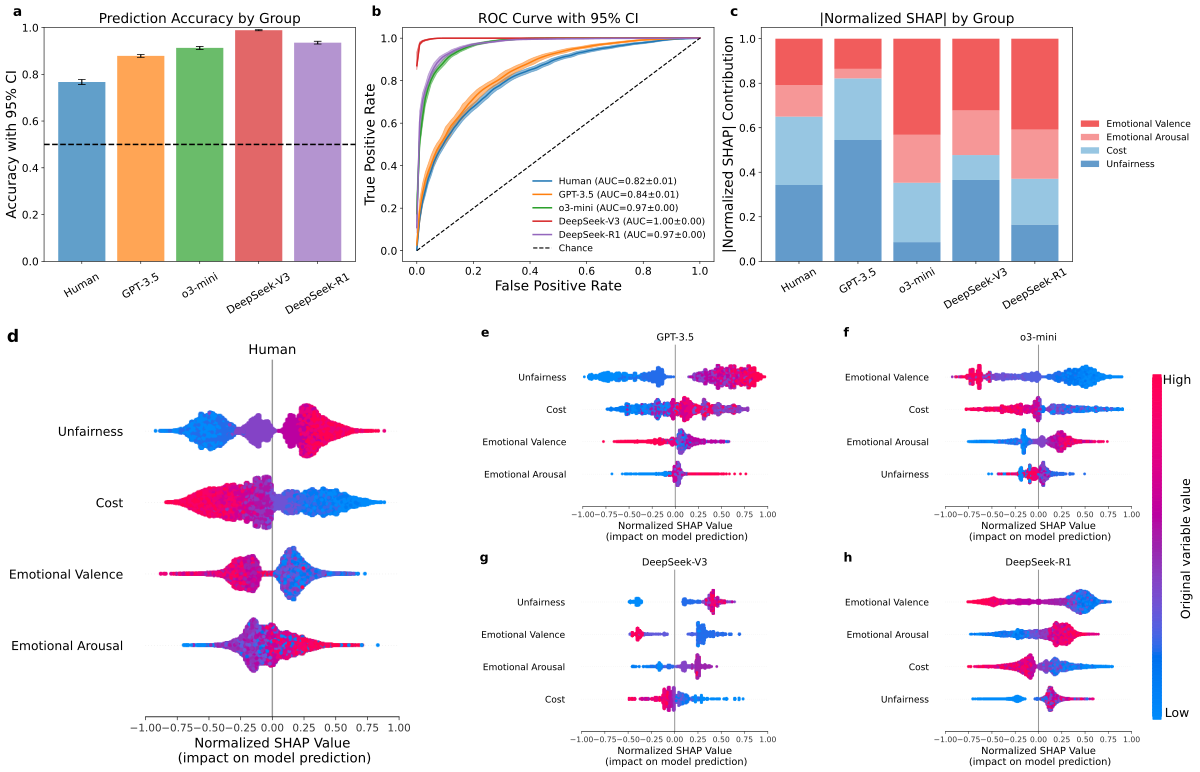

In [12]:
from lxml import etree
from IPython.display import SVG, display

upper_file = "merged_performance.svg"
lower_file = "merged_shap_dot.svg"
out_file = "merged_combined.svg"

fig_width_px = 1200  
NSMAP = {None: "http://www.w3.org/2000/svg"}
svg_root = etree.Element("svg", nsmap=NSMAP)
svg_root.set("width", f"{fig_width_px}px")
svg_root.set("version", "1.1")

bg = etree.Element("rect", x="0", y="0", width=str(fig_width_px), height="10000", fill="white")
svg_root.append(bg)


# performance in the top
tree_upper = etree.parse(upper_file)
upper_svg = tree_upper.getroot()
orig_w = float(upper_svg.get("width").replace("pt","").replace("px",""))
orig_h = float(upper_svg.get("height").replace("pt","").replace("px",""))
scale_upper = fig_width_px / orig_w
upper_h_scaled = orig_h * scale_upper

g_upper = etree.Element("g")
g_upper.set("transform", f"translate(0,0) scale({scale_upper})")
for child in upper_svg:
    g_upper.append(child)
svg_root.append(g_upper)


# SHAP in the bottom
tree_lower = etree.parse(lower_file)
lower_svg = tree_lower.getroot()
orig_w = float(lower_svg.get("width").replace("pt","").replace("px",""))
orig_h = float(lower_svg.get("height").replace("pt","").replace("px",""))
scale_lower = fig_width_px / orig_w
lower_h_scaled = orig_h * scale_lower

g_lower = etree.Element("g")
g_lower.set("transform", f"translate(0,{upper_h_scaled}) scale({scale_lower})")
for child in lower_svg:
    g_lower.append(child)
svg_root.append(g_lower)


svg_root.set("height", f"{upper_h_scaled + lower_h_scaled}px")
tree_out = etree.ElementTree(svg_root)
tree_out.write(out_file, encoding="utf-8", xml_declaration=True)

display(SVG(filename=out_file))

## Results of Distance between each LMM and Human

supplementary table 5.3.1

In [13]:
from scipy import stats

# get group results of Emotion and Cost/Rationality Contributions with 95% CI
df = pd.read_csv("shap_results_weighted.csv")
df_avg = df.groupby(['group', 'id'], as_index=False)[['NormSHAP_E', 'NormSHAP_R']].mean()

def calculate_confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = data.mean()
    stderr = data.sem()
    interval = stats.t.interval(confidence, n-1, loc=mean, scale=stderr)
    return interval

Weightetd_NormSHAP_mean = df_avg.groupby('group').apply(
    lambda x: pd.Series({
        'E_mean': x['NormSHAP_E'].mean(),
        'E_ci_lower': calculate_confidence_interval(x['NormSHAP_E'])[0],
        'E_ci_upper': calculate_confidence_interval(x['NormSHAP_E'])[1],
        'R_mean': x['NormSHAP_R'].mean(),
        'R_ci_lower': calculate_confidence_interval(x['NormSHAP_R'])[0],
        'NormSHAP_R_ci_upper': calculate_confidence_interval(x['NormSHAP_R'])[1]
    })
).reset_index()

Weightetd_NormSHAP_mean = Weightetd_NormSHAP_mean.round(3)
print(Weightetd_NormSHAP_mean.to_string())

         group  E_mean  E_ci_lower  E_ci_upper  R_mean  R_ci_lower  NormSHAP_R_ci_upper
0  DeepSeek-R1   0.556       0.551       0.560  -0.182      -0.185               -0.180
1  DeepSeek-V3   0.444       0.443       0.446  -0.091      -0.091               -0.090
2      GPT-3.5   0.079       0.077       0.081   0.142       0.142                0.143
3        Human   0.189       0.183       0.195  -0.286      -0.288               -0.285
4      o3-mini   0.567       0.563       0.572  -0.229      -0.231               -0.227


supplementary table 5.3.4

In [14]:
import pandas as pd
import numpy as np
from scipy.spatial import distance

#The average distances of each agent in each LLM and humans

df = pd.read_csv("shap_results_weighted.csv")
df_avg = df.groupby(['group', 'id'], as_index=False)[['NormSHAP_E', 'NormSHAP_R']].mean()

human_data = df_avg[df_avg['group'] == 'Human'][['NormSHAP_E', 'NormSHAP_R']].values
groups_nonhuman = df_avg[df_avg['group'] != 'Human']['group'].unique()

dist_list = ['euclidean', 'seuclidean', 'manhattan', 'cosine', 'mahalanobis', 'pearson', 'spearman']
VI = np.linalg.pinv(np.cov(human_data, rowvar=False))  

rows = []
for g in groups_nonhuman:
    g_sub = df_avg[df_avg['group'] == g][['id', 'NormSHAP_E', 'NormSHAP_R']].reset_index(drop=True)
    
    D_euc  = distance.cdist(g_sub[['NormSHAP_E', 'NormSHAP_R']].values,
                            human_data, 'euclidean')
    D_seuc  = distance.cdist(g_sub[['NormSHAP_E', 'NormSHAP_R']].values,
                            human_data, 'seuclidean')
    D_man  = distance.cdist(g_sub[['NormSHAP_E', 'NormSHAP_R']].values,
                            human_data, 'cityblock')
    D_cos  = distance.cdist(g_sub[['NormSHAP_E', 'NormSHAP_R']].values,
                            human_data, 'cosine')
    D_mah  = distance.cdist(g_sub[['NormSHAP_E', 'NormSHAP_R']].values,
                            human_data, 'mahalanobis', VI=VI)
    # average for each agent
    for i, oid in enumerate(g_sub['id']):
        row = {'id': oid, 'Group': g}
        row['euclidean']  = D_euc[i, :].mean()
        row['seuclidean']  = D_seuc[i, :].mean()
        row['manhattan']  = D_man[i, :].mean()
        row['cosine']     = D_cos[i, :].mean()
        row['mahalanobis'] = D_mah[i, :].mean()
        rows.append(row)

df_dist = pd.DataFrame(rows)
df_dist.to_csv("dist_id.csv", index=False)

In [15]:
import pandas as pd

# mean with s.d.
# df_dist = pd.read_csv("df_dist_id.csv")
dist_mean = df_dist.groupby('Group')[['euclidean','seuclidean', 'manhattan', 'cosine', 'mahalanobis']].agg(['mean', 'std'])
dist_mean = dist_mean.map(lambda x: f"{x:.3f}")

for col in ['euclidean','seuclidean', 'manhattan', 'cosine', 'mahalanobis']:
    dist_mean[col] = dist_mean[(col, 'mean')] + "(" + dist_mean[(col, 'std')] + ")"

dist_mean = dist_mean[[
    ('euclidean', 'mean'),
    ('seuclidean', 'mean'),
    ('manhattan', 'mean'),
    ('cosine', 'mean'),
    ('mahalanobis', 'mean')
]]

dist_mean.columns = ['euclidean', 'seuclidean', 'manhattan', 'cosine', 'mahalanobis']
dist_mean = dist_mean.T
dist_mean.columns.name = None
dist_mean = dist_mean.reset_index().rename(columns={'index': 'distance'})

print("Distance with M(SD):")
print(dist_mean)

dist_mean.to_csv("mean_points_distances.csv", index=False)

Distance with M(SD):
      distance   DeepSeek-R1   DeepSeek-V3        GPT-3.5       o3-mini
0    euclidean  0.383(0.081)  0.327(0.021)   0.454(0.013)  0.384(0.073)
1   seuclidean  2.526(0.688)  2.681(0.147)   2.549(0.190)  2.424(0.719)
2    manhattan  0.471(0.113)  0.451(0.029)   0.559(0.029)  0.438(0.098)
3       cosine  0.260(0.065)  0.338(0.018)   1.473(0.159)  0.221(0.051)
4  mahalanobis  5.879(1.724)  8.893(0.383)  18.999(0.278)  4.721(1.261)


supplementary table 5.3.5

In [16]:
from scipy.stats import ttest_rel
import itertools

# paired t-test
def significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'
    
# df_dist = pd.read_csv("df_dist_id.csv")  
groups = df_dist['Group'].unique()
dist_paired_results = []
num_tests_per_dist = len(groups) * (len(groups) - 1) // 2 

for dist in ['euclidean', 'seuclidean', 'manhattan', 'cosine', 'mahalanobis']:
    for g1, g2 in itertools.combinations(groups, 2):
        data1 = df_dist[df_dist['Group'] == g1][dist]
        data2 = df_dist[df_dist['Group'] == g2][dist]
        
        diff = data1.values - data2.values
        t_stat, p_value = ttest_rel(data1, data2)
        
        cohen_d = diff.mean() / ((data1.values.std()**2 + data2.values.std()**2) / 2)**0.5
        
        dist_paired_results.append({
            'Distance': dist,
            'Group1': g1,
            'Group2': g2,
            't_stat': t_stat,
            'Cohen_d': cohen_d,
            'p_Bonferroni': min(p_value * num_tests_per_dist, 1)
        })

dist_paired_results = pd.DataFrame(dist_paired_results)

dist_paired_results['significance'] = dist_paired_results['p_Bonferroni'].apply(significance_stars)
dist_paired_results['p_Bonferroni'] = dist_paired_results['p_Bonferroni'].apply(lambda x: f"{x:.2e}")

print("Paired t-test (Bonferroni)：")
print(dist_paired_results[['Distance', 'Group1', 'Group2', 't_stat', 'Cohen_d', 'p_Bonferroni', 'significance']].to_string())
dist_paired_results.to_csv("pairwise_t_test_results.csv", index=False)


Paired t-test (Bonferroni)：
       Distance       Group1       Group2      t_stat    Cohen_d p_Bonferroni significance
0     euclidean  DeepSeek-R1  DeepSeek-V3   24.861484   0.942360    3.50e-106          ***
1     euclidean  DeepSeek-R1      GPT-3.5  -28.866275  -1.220747    1.64e-133          ***
2     euclidean  DeepSeek-R1      o3-mini   -0.756556  -0.015057     1.00e+00           ns
3     euclidean  DeepSeek-V3      GPT-3.5 -167.789693  -7.260284     0.00e+00          ***
4     euclidean  DeepSeek-V3      o3-mini  -26.914611  -1.068579    4.16e-120          ***
5     euclidean      GPT-3.5      o3-mini   32.440231   1.340690    3.06e-158          ***
6    seuclidean  DeepSeek-R1  DeepSeek-V3   -8.145552  -0.312309     6.60e-15          ***
7    seuclidean  DeepSeek-R1      GPT-3.5   -1.094028  -0.044601     1.00e+00           ns
8    seuclidean  DeepSeek-R1      o3-mini    7.403042   0.144833     1.67e-12          ***
9    seuclidean  DeepSeek-V3      GPT-3.5   18.784448   0.7827

## Figure Distance between each LMM and Human

figure 5

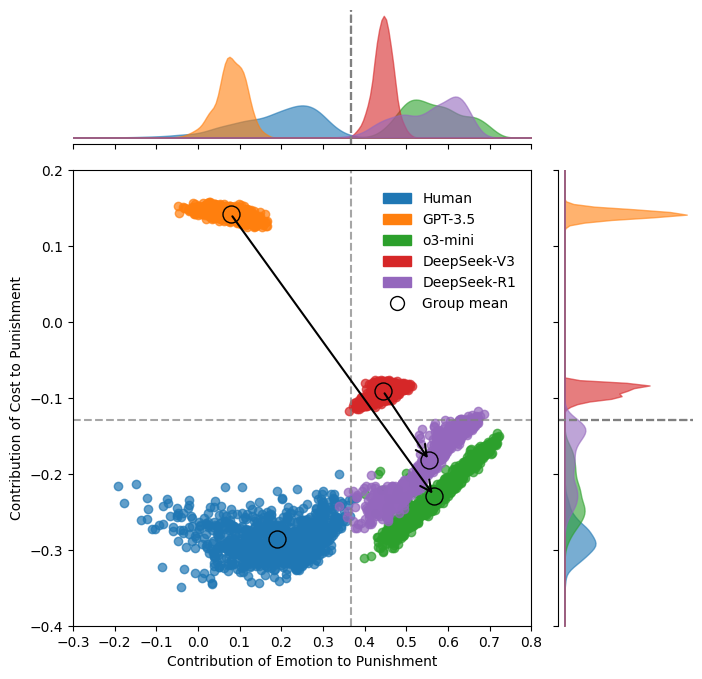

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

df = pd.read_csv("shap_results_weighted.csv")
feature_cols = ["E", "R"]
shap_cols = ["NormSHAP_" + f for f in feature_cols]

df_mean = df.groupby(['group', 'id'])[shap_cols].mean().reset_index()

groups = ["Human","GPT-3.5", "o3-mini", "DeepSeek-V3", "DeepSeek-R1"]
colors = plt.cm.tab10.colors[:5]  


fig = plt.figure(figsize=(8, 8))
gs = GridSpec(4, 4, figure=fig)
ax_scatter = fig.add_subplot(gs[1:,:3])  
ax_top = fig.add_subplot(gs[0,:3], sharex=ax_scatter)   
ax_right = fig.add_subplot(gs[1:,3], sharey=ax_scatter) 

group_means = {}
all_mean = df_mean[shap_cols].mean()

# plots
for i, group in enumerate(groups):
    sub_df = df_mean[df_mean['group'] == group]
    ax_scatter.scatter(sub_df['NormSHAP_E'], sub_df['NormSHAP_R'],
                       alpha=0.7, label=group, color=colors[i])
                       
for i, group in enumerate(groups):
    sub_df = df_mean[df_mean['group'] == group]
    mean_x = sub_df['NormSHAP_E'].mean()
    mean_y = sub_df['NormSHAP_R'].mean()
    group_means[group] = (mean_x, mean_y)
    ax_scatter.scatter(mean_x, mean_y,
                       color=colors[i], edgecolor='black', s=150)

ax_scatter.set_xlim(-0.3, 0.8)
ax_scatter.set_ylim(-0.4, 0.2)
ax_scatter.set_xticks(np.linspace(-0.3, 0.8, int((0.8 - (-0.3)) / 0.1) + 1))

ax_scatter.axhline(y=all_mean['NormSHAP_R'], color='grey', linestyle='--', alpha=0.7)
ax_scatter.axvline(x=all_mean['NormSHAP_E'], color='grey', linestyle='--', alpha=0.7)

ax_scatter.set_xlabel('Contribution of Emotion to Punishment')
ax_scatter.set_ylabel('Contribution of Cost to Punishment')

ax_scatter.annotate('', xy=group_means['o3-mini'], xytext=group_means['GPT-3.5'],
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5, mutation_scale=20))
ax_scatter.annotate('', xy=group_means['DeepSeek-R1'], xytext=group_means['DeepSeek-V3'],
             arrowprops=dict(arrowstyle='->', color='black', lw=1.5, mutation_scale=20))

# legend
patches = [mpatches.Patch(color=colors[i], label=groups[i]) for i in range(len(groups))]
mean_marker = mlines.Line2D([], [], color='white', marker='o', markerfacecolor='white',
                            markeredgecolor='black', markersize=10, label='Group mean')
ax_scatter.legend(handles=patches + [mean_marker], loc='upper left',
                  bbox_to_anchor=(.65, 0.98), frameon=False)

# density
x_vals = np.linspace(-0.3, 0.8, 200)
y_vals = np.linspace(-0.4, 0.3, 200)

for i, group in enumerate(groups):
    sub_df = df_mean[df_mean['group'] == group]

    kde_x = gaussian_kde(sub_df['NormSHAP_E'])
    ax_top.fill_between(x_vals, kde_x(x_vals), color=colors[i], alpha=0.6)
    ax_top.axvline(x=all_mean['NormSHAP_E'], color='grey', linestyle='--', alpha=0.7)

    kde_y = gaussian_kde(sub_df['NormSHAP_R'])
    ax_right.fill_betweenx(y_vals, kde_y(y_vals), color=colors[i], alpha=0.6)
    ax_right.axhline(y=all_mean['NormSHAP_R'], color='grey', linestyle='--', alpha=0.7)



for spine in ["top","right","left"]:
    ax_top.spines[spine].set_visible(False)
ax_top.spines["bottom"].set_visible(True)

for spine in ["top","right","bottom"]:
    ax_right.spines[spine].set_visible(False)
ax_right.spines["left"].set_visible(True)

plt.setp(ax_top.get_xticklabels(), visible=False)
plt.setp(ax_right.get_yticklabels(), visible=False)
ax_top.get_yaxis().set_visible(False)    
ax_right.get_xaxis().set_visible(False)   

fig.savefig("Emotion-Cost_Contribution.svg", format="svg", bbox_inches='tight', bbox_extra_artists=[txt])
plt.show()

## Figure of SHAP by conditions

supplementary figure 5.2.1

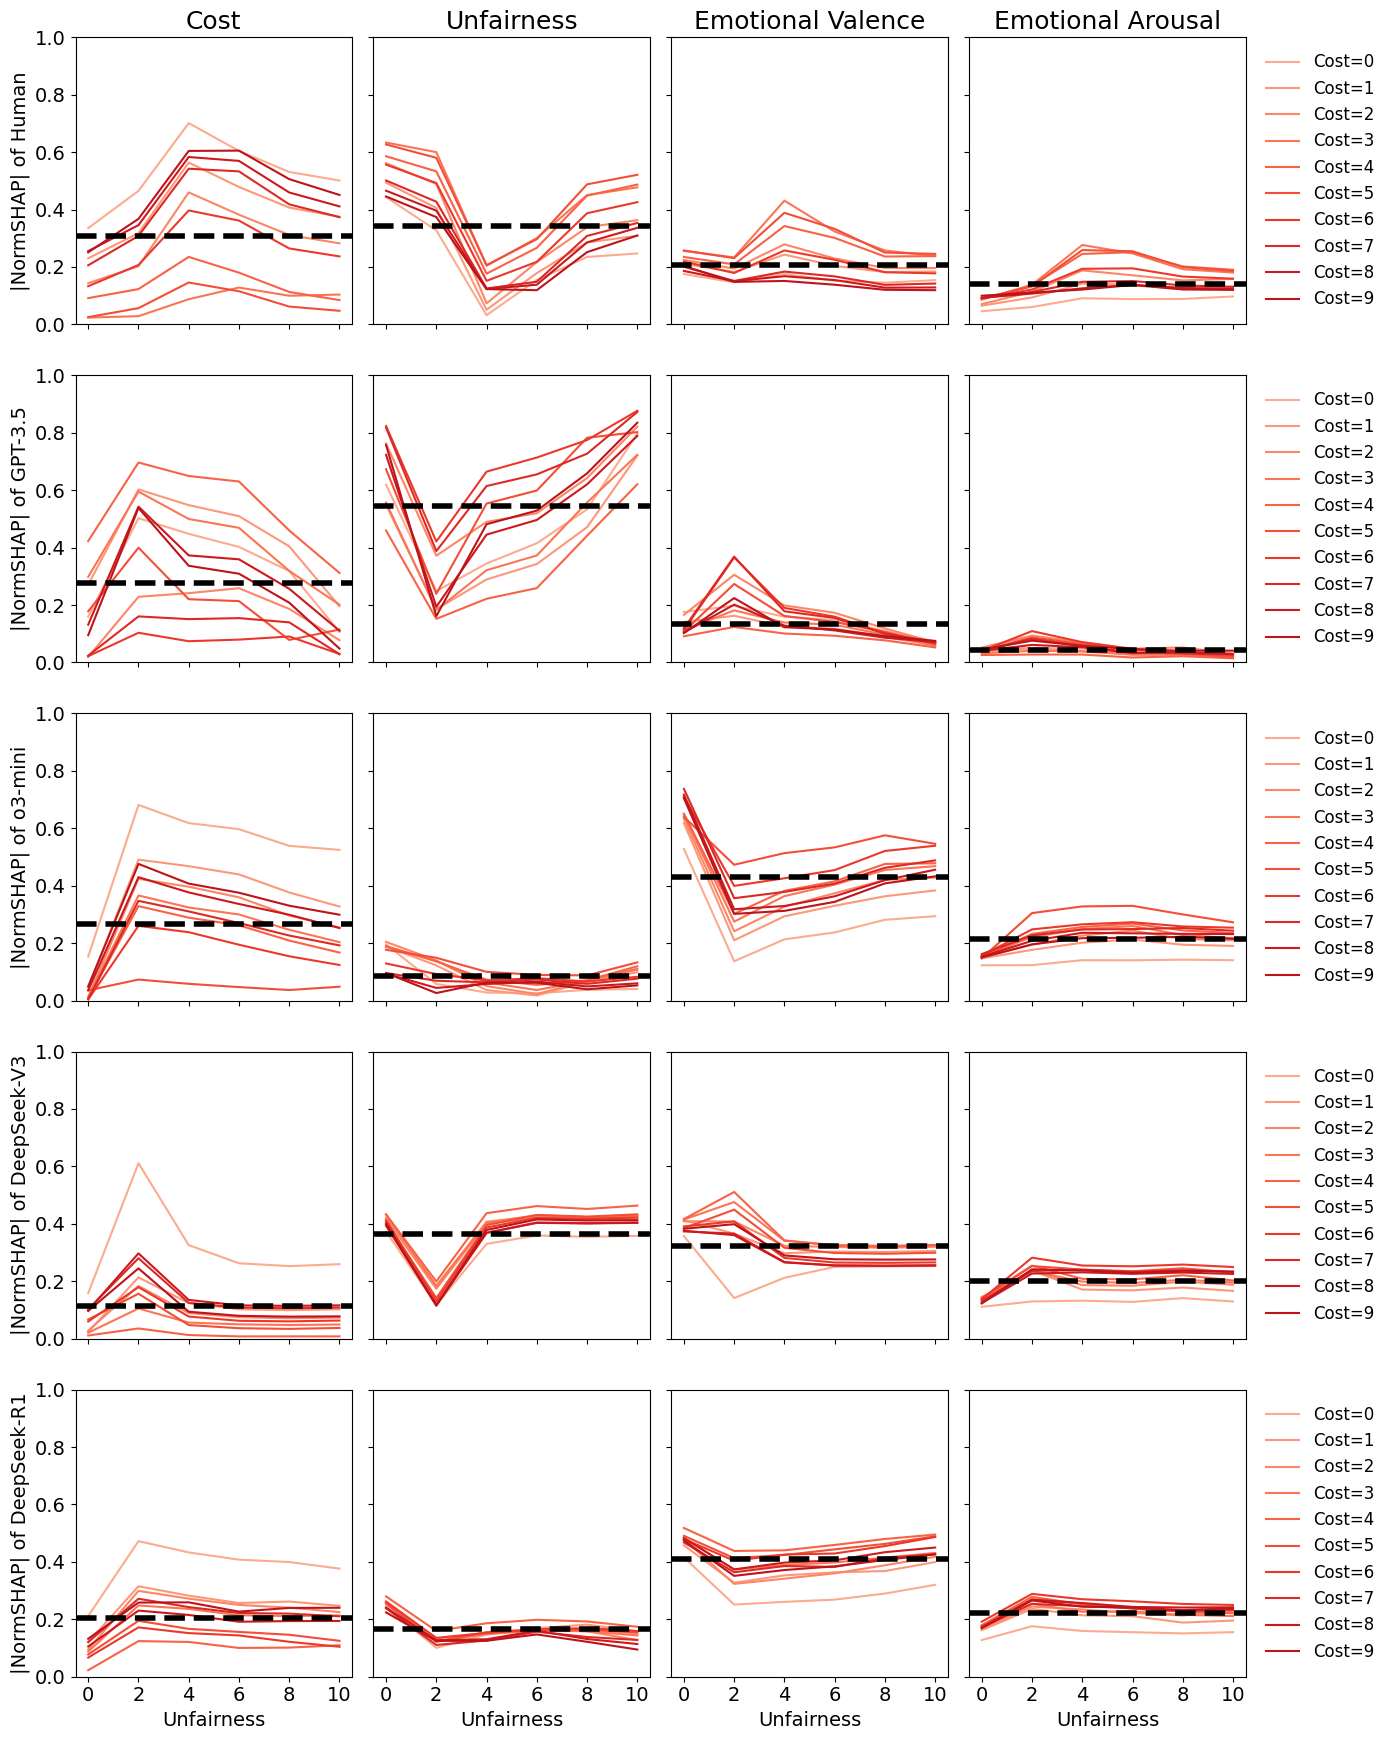

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# The figure is shown in the Supplementary Materials

df = pd.read_csv("shap_results_weighted.csv")
feature_cols = ["Cost", "Unfairness", "Emotional Valence", "Emotional Arousal"]
shap_cols = ["NormSHAP_" + f for f in feature_cols]
df[shap_cols] = df[shap_cols].abs()

df_agg = df.groupby(['group','Cost','Unfairness'])[shap_cols].mean().reset_index()

groups_order = ['Human','GPT-3.5','o3-mini','DeepSeek-V3','DeepSeek-R1']
n_groups = len(groups_order)
n_shap = len(shap_cols)

fig, axes = plt.subplots(n_groups, n_shap, figsize=(3.5*n_shap, 3.5*n_groups), sharex='col', sharey='row')
axes = np.array(axes)

font_main = 18  
font_legend = 12  
labelsize = 14 

for i, g in enumerate(groups_order):
    df_g = df_agg[df_agg['group'] == g]
    costs = sorted(df_g['Cost'].unique())
    n_costs = len(costs)
    
    colors = [cm.Reds(0.3 + k/(n_costs-1) * 0.5) for k in range(n_costs)]
    
    for j, col in enumerate(shap_cols):
        ax = axes[i, j] if n_groups > 1 else axes[j]
        ax.set_facecolor('white')
        ax.set_ylim(0, 1)

        for k, c in enumerate(costs):
            df_line = df_g[df_g['Cost'] == c].sort_values('Unfairness')
            ax.plot(df_line['Unfairness'], df_line[col], color=colors[k], label=f"Cost={c}")
       
        mean_value = df_g[col].mean() 
        ax.axhline(mean_value, color='black', linestyle='--', linewidth=4)
        
        if i == 0:
            ax.set_title(col.replace("NormSHAP_", ""),fontsize=font_main)
        if j == 0:
            ax.set_ylabel(f"|NormSHAP| of {g}",fontsize=labelsize)
        if i == n_groups - 1:
            ax.set_xlabel("Unfairness",fontsize=labelsize)
        if j == n_shap-1:
            ax.legend(fontsize=font_legend, frameon=False, bbox_to_anchor=(1.02, 0.5), loc='center left')
        
                
        ax.set_xlim(-0.5, 10.5)
        ax.set_xticks([0, 2, 4, 6, 8, 10])
        ax.tick_params(axis='both', labelsize=labelsize) 
        ax.grid(False)


plt.tight_layout()

fig.savefig("SHAP_by_conditions.svg", format="svg", bbox_inches='tight')

plt.show()
